In [14]:
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from utils.Types import Chromosome
from utils.Operators import Crossover, Mutation, Selection, build_custom_mutation
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [15]:
from utils.models import MLP
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

N_EPOCHS = 10
CLIP_GRAD = 1.0
def evaluate_fitness(chromosome, train_loader, val_loader):    
    chromosome = chromosome.to_dict()
    model = MLP(input_size=5, output_size=1, **chromosome).to(device)
    
    initial_lr = 1e-2
    final_lr = 1e-4
    gamma = (final_lr / initial_lr) ** (1 / N_EPOCHS)
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)
    criterion = nn.MSELoss()
    
    for _ in range(N_EPOCHS):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD)
            loss.backward()
            optimizer.step()

        lr_scheduler.step()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                val_loss += criterion(y_pred, y)
        val_loss /= len(val_loader)
    
    return -val_loss.item()


def fitness_evaluator(chromosomes, data):
    train_loader, val_loader = data
    return [evaluate_fitness(chromosome, train_loader, val_loader) for chromosome in chromosomes]

In [16]:
Chromosome.set_domain({
    'hidden_size': (4, 32),
    'activation': [0, 1],
})

def population_initializer(population_size):
    return [Chromosome() for _ in range(population_size)]

## Genetic Algorithm

In [17]:
POP_SIZE = 4

In [18]:
# Load the dataset
df = pd.read_parquet('datasets/sinewave.parquet')
df_train, df_val = train_test_split(df, test_size=0.2, random_state=SEED)

# Split the data into features and target
X_train, y_train = df_train.drop(columns=['Target']), df_train['Target']
X_val, y_val = df_val.drop(columns=['Target']), df_val['Target']

y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)

# Standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [19]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
custom_mutation = build_custom_mutation({
    slice(0, 1) : lambda x: Mutation.uniform_mutation(x, 0.75, -4, 4),
    slice(1, 2) : Mutation.bit_flip_mutation
})

In [21]:
from utils.GeneticAlgorithm import GeneticAlgorithm

ga = GeneticAlgorithm(
    population_initializer  = population_initializer,
    fitness_evaluator       = fitness_evaluator,
    selection_operator      = lambda pop, fitness : Selection.tournament_selection(pop , fitness, 2),
    crossover_pairing       = Crossover.half_pairs,
    crossover_operator      = Crossover.uniform_crossover,
    mutation_operator       = custom_mutation,
    termination_condition   = lambda fitness_values : np.max(fitness_values) == 0
)

In [22]:
ga.run(
    (train_loader, val_loader),
    POP_SIZE,
    max_generations=20,
)

Generations:   0%|          | 0/20 [00:00<?, ?it/s]

In [23]:
best_fitness_history = [
    max(fit) for fit in ga.history['fitness']
]
average_fitness_history = [
    np.mean(fit) for fit in ga.history['fitness']
]
std_fitness_history = [
    np.std(fit) for fit in ga.history['fitness']
]

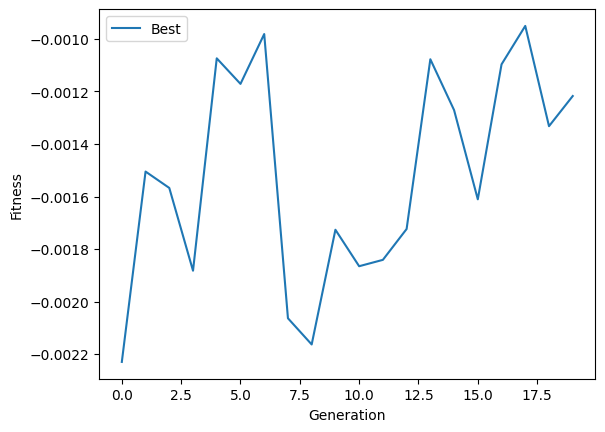

In [24]:
plt.plot(best_fitness_history, label='Best')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.show()

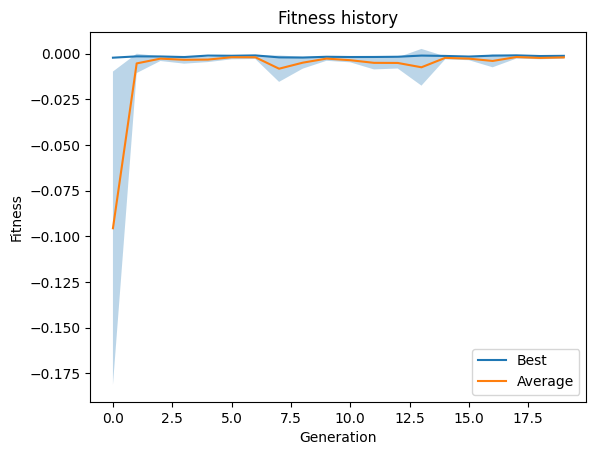

In [25]:
# Plot the fitness history with mean and std
plt.plot(best_fitness_history, label='Best')
plt.plot(average_fitness_history, label='Average')
plt.fill_between(
    range(len(best_fitness_history)),
    np.array(average_fitness_history) - np.array(std_fitness_history),
    np.array(average_fitness_history) + np.array(std_fitness_history),
    alpha=0.3
)
plt.legend()
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness history')
plt.show()

In [26]:
for generation in ga.history['population']:
    print([ g.value for g in generation ])
    
print('Best chromosome:', ga.best_chromosome.value)
print('Best fitness:', ga.best_fitness)

[[24, 0], [4, 1], [11, 0], [8, 0]]
[[20, 0], [28, 1], [24, 0], [22, 0]]
[[25, 0], [24, 0], [30, 0], [29, 1]]
[[30, 0], [29, 1], [21, 0], [23, 1]]
[[30, 0], [30, 1], [32, 0], [32, 1]]
[[32, 1], [28, 0], [27, 0], [32, 0]]
[[25, 1], [27, 0], [31, 0], [24, 0]]
[[20, 0], [25, 1], [22, 0], [22, 1]]
[[25, 1], [25, 0], [23, 1], [19, 0]]
[[21, 0], [23, 1], [24, 0], [27, 0]]
[[23, 1], [23, 0], [18, 0], [20, 1]]
[[20, 1], [20, 1], [24, 0], [23, 1]]
[[16, 1], [26, 0], [27, 1], [22, 0]]
[[31, 0], [27, 0], [24, 1], [24, 1]]
[[32, 1], [27, 1], [27, 0], [28, 1]]
[[30, 0], [32, 0], [32, 0], [26, 0]]
[[32, 0], [22, 1], [32, 1], [24, 0]]
[[30, 1], [32, 0], [30, 1], [28, 1]]
[[31, 0], [32, 0], [30, 1], [32, 1]]
[[30, 1], [32, 0], [31, 0], [31, 0]]
[[31, 1], [31, 1], [32, 1], [31, 1]]
Best chromosome: [32, 0]
Best fitness: -0.0009503753390163183
